# Homework 5

Daniil Sherki

MSc-1, Petroleum Engineering



# Question 1: Min volume ellipsoid (2 points)

Consider

$$ \varepsilon_0 = \{ \mathbf{x}:\mathbf{x}^{\top} P_0^{-1} \mathbf{x} \leq 1\}$$

$$
P_0 = 
\begin{bmatrix}
    1 & 0 \\
    0 & 4 \\
\end{bmatrix}
$$

Construct (give the formula and plot) the min volume ellipsoid that covers: $\varepsilon_0 \cap \{ \mathbf{x}: W \mathbf{x} \leq 0\} $ for:
*   $W = [1;0]$
*   $W = [\frac{1}{2}; -\frac{1}{2}]$

Provide $\frac{vol(\varepsilon)}{vol(\varepsilon_0)}$ for both cases.



## Solution

### Formula's part

$$
\min_{P,c} Vol(\varepsilon) \\
s.t. \\
(x_i-c)^T P (x_i-c) \leq 1, \quad \forall i=1,\cdots N \\
P \succ 0
$$


Let's rewrite the formula of our ellipsoid

$$
(x-c)^T P (x-c) = (x-c)^TAA(x-c) = (A(x-c))^T(A(x-c)) = (Ax - Ac)^T (Ax-Ac) = (Ax+b)^T(Ax+b) = ||Ax+b||_2^2 \leq 1
% u^T u = ||u||_2^2 \leq 1
$$

Here $b = -Ac$; denote $u=Ax+b$; $B = \{u \, |\, ||u||_2^2 \leq 1  \}$ - a unit ball

If $x \in \varepsilon$ then $||Ax+b||^2 \leq 1$ holds


$$
u = Ax + b \Rightarrow
x = A^{-1}u - A^{-1}b = A^{-1}u + c
$$

If $u$ is a point of a unit ball B, $x$ is a point of an epllipsoid $\varepsilon$, then $A$ is an affine mapping from $\varepsilon$ to $B$, and $A^{-1}$ is a reverse mapping (from $B$ to $\varepsilon$) 

Then, 

$$
Vol(\varepsilon) \propto \det(A^{-1}) \cdot Vol(B) = \det(A^{-1})
$$

Reference: Ellipsoid seminar.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

P = np.array([[1, 0], [0, 4]]).astype('float64')
w1 = np.reshape(np.array([1, 0]).astype('float64'), (2, 1))
w2 = np.reshape(np.array([0.5, -0.5]).astype('float64'), (2, 1))
x = np.reshape(np.array([0, 0]).astype('float64'), (2, 1))

In [2]:
def elips_method_step(x_c, P, w, n=2):
    x_c -= 1/(n+1) * (P @ w)/np.sqrt(w.T @ P @ w)
    P = n**2/(n**2 - 1) * (P - 2/(n+1) * (P @ w @ w.T @ P)/(w.T @ P @ w))
    return x_c, P

In [3]:
# recall that ϵ is ||Ax+b||^2 <= 1
def elips_vis(A, b, M=100, labels=['elips', 'center'], modes=['g--', 'rd']):
    c = np.linalg.inv(A) @ b
    t = np.linspace(0, 2*np.pi, M)
    u = np.array([np.sin(t), np.cos(t)]).T  # unit ball
    ELP = np.array([np.linalg.inv(A) @ u[i, :] - c for i in range(M)])  # ϵ
    plt.plot(*ELP.T, modes[0], label=labels[0])
    plt.plot(*-c.T, modes[1],  label=labels[1])
    
def vol_eps(A):
    A_inv = np.linalg.inv(A)
    return np.linalg.det(A_inv)


def compare_elips_plot(w, title='elips w1', shape=(3, 6), labels=['e1', 'c1'], modes=['b--', 'r*']):
    plt.figure(figsize=shape)
    L = np.linalg.cholesky(np.linalg.inv(P))
    vol0 = vol_eps(L)
    elips_vis(L, np.array([0, 0]))
    x1, P1 = elips_method_step(x, P, w)
    L1 = np.linalg.cholesky((np.linalg.inv(P1)))
    vol = vol_eps(L1)
    b1 = np.reshape(- L1 @ x1, (2,))
    elips_vis(L1, b1,
              labels=labels,
              modes=modes)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    return vol0, vol

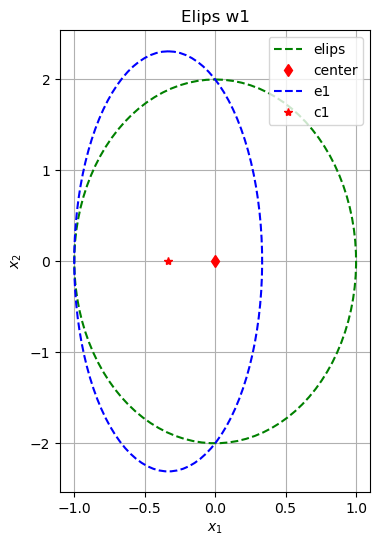

In [4]:
vol0, vol1 = compare_elips_plot(w1, 'Elips w1', shape=(4, 6))

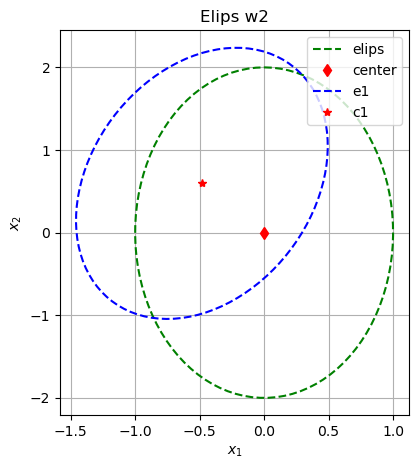

In [5]:
_, vol2 = compare_elips_plot(w2, 'Elips w2', shape=(4.5, 5))

In [6]:
print('For w1 vol(e)/vol(e0) = ', vol1/vol0)
print('For w2 vol(e)/vol(e0) = ', vol2/vol0)

For w1 vol(e)/vol(e0) =  0.769800358919501
For w2 vol(e)/vol(e0) =  0.7698003589195009


# Question 2: ADMM for LASSO (3 points)

Solve the following problem:

$$ \min_x \frac{1}{2} \Vert Ax - b \Vert^2_2 + \lambda \Vert x \Vert_1 $$

$$ A: m \times n, m < n $$

$$ x: n \times 1 $$


Define the problem parameters:

*   $n = 250$, $m = 75$, $A_{ij} \sim \mathcal{N}(0,1)$, normalize columns of $A: a \rightarrow \frac{a}{\Vert a \Vert_2}$
* generate $x^*$ with 5 non-zero entries $\sim \mathcal{N}(0,1)$
* $b = A x^* + \xi, \
xi \sim \mathcal{N}(0, 10^{-2}I)$
* $\lambda = 0.1 \Vert A^{\top} b\Vert_{\infty}$, for $\lambda > \Vert A^{\top}b \Vert_{\infty} $ you'll get $x = 0$ - because of too large penalization term $\lambda \Vert x \Vert_1$

Run ADMM (use $\rho = 1, r^k = x^k −z^k, \Vert r^k \Vert_2 \leq 10^{−4}$ as a stopping criterion) and any
other (e.g. first-order) unconstrained optimization method. Compare convergence and CPU
time.



## Solution

### 0. General manipulations

In [7]:
import numpy as np
import random
import pandas as pd

n, m = 250, 75
A = np.random.randn(m, n)
for i in range(A.shape[1]):
    norm = np.linalg.norm(A[:, i])
    for j in range(A.shape[0]):
        A[j, i] = A[j, i]/norm
x_star = np.zeros((n, 1))

for i in range(5):
    pos = random.randint(0, n-1)
    x_star[pos, 0] = np.random.randn(1)

xi = np.random.randn(m, 1)/100
b = A@x_star + xi
lmbd = 0.1 * np.linalg.norm(A.T @ b, np.inf)


def task2_func(x):
    return 0.5*np.power(np.linalg.norm(np.dot(A, x) - b), 2) + lmbd*np.linalg.norm(x, 1)

### 1. ADMM for LASSO implementation

In [8]:
def task2_func_z(x, z):
    '''
    :param x: numpy.ndarray;
    :param z: numpy.ndarray;
    :return: float.
    '''
    return 0.5*np.power(np.linalg.norm(np.dot(A, x) - b), 2) + lmbd*np.linalg.norm(z, 1)


def soft_threshold(a, rho):
    '''
    :param x: numpy.ndarray;
    :return: numpy.ndarray.
    '''
    cond = lmbd/rho
    for i in range(len(a)):
        if a[i] > cond:
            a[i] -= cond
        if a[i] < -1*cond:
            a[i] += cond
        else:
            a[i] = 0
    return a


def admm_for_lasso(x0, tol, rho=1, func=task2_func_z):
    '''
    :param x: numpy.ndarray;
    :param tol: flaot;
    :param rho: float;
    :return: pd.DataFrame, list.
    '''
    x, z, u = x0, np.zeros_like(x0), np.zeros_like(x0)
    k = 0
    x_arr, f_arr, k_arr = [x0], [func(x, z)], [k]

    while np.linalg.norm(x - z) > tol:
        k += 1
        x = np.dot(np.linalg.inv(np.dot(A.T, A)+rho*np.eye(n, n)),
                   (np.dot(A.T, b)+rho*(z - u)))
        z = soft_threshold(x + u, rho)
        u += x - z

        x_arr.append(x)
        f_arr.append(func(x, z))
        k_arr.append(k)

    df = pd.DataFrame({'step': k_arr, 'f': f_arr})
    return df, x_arr

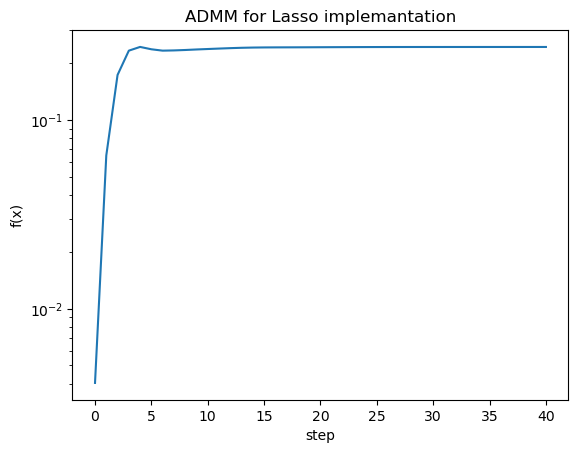

Performance time is 0.399031833 seconds.
||x*|| = 1.1732209802578966, f* = 0.24467659395022595


In [9]:
import time
import matplotlib.pyplot as plt

t1 = time.perf_counter()
# df, x_arr = admm_for_lasso(np.ones((n,1))/3, 1e-4)
df, x_arr = admm_for_lasso(x_star, 1e-4)
t2 = time.perf_counter() - t1

plt.plot(df.step, df.f)
plt.xlabel(r'step')
plt.ylabel(r'f(x)')
plt.title('ADMM for Lasso implemantation')
plt.yscale('log')
plt.show()

print(f'Performance time is {t2} seconds.')
print(fr'||x*|| = {np.linalg.norm(x_arr[-1])}, f* = {df.f.iloc[-1]}')

In [10]:
0.5*np.power(np.linalg.norm(np.dot(A, np.array(x_arr[-1])) - b), 2)

0.08548904197987696

### 2. Unconstrained optimization first-order method: Gradient Descent

We can find the gradient of this function by taking the partial derivative with respect to each component of $x$. Let $f(x) = \frac{1}{2} \Vert Ax - b \Vert^2_2 + \lambda \Vert x \Vert_1$, then

\begin{align*}
\frac{\partial f}{\partial x_i} &= \frac{\partial}{\partial x_i} \left(\frac{1}{2} \Vert Ax - b \Vert^2_2\right) + \frac{\partial}{\partial x_i} \left(\lambda \Vert x \Vert_1\right) \\
&= \sum_{j=1}^n (Ax-b)_j \frac{\partial}{\partial x_i} (A_{j,i}x_i) + \lambda \frac{\partial}{\partial x_i} |x_i| \\
&= \sum_{j=1}^n (Ax-b)_j A_{j,i} + \lambda \text{sign}(x_i),
\end{align*}

where $\text{sign}(x_i)$ is the sign of $x_i$. Therefore, the gradient of $f(x)$ is

$$
\nabla f(x) = A^T(Ax-b) + \lambda \text{sign}(x).
$$



In [11]:
'''
Simple gradient descent (GD): for this task
we use jax for automatical taking gradient
of function f, because manhattan-norm
can not derivated
'''

import jax
import jax.numpy as jnp

A_jax, x_star_jax, b_jax = jnp.array(A), jnp.array(x_star), jnp.array(b)


def task2_func_jax(x):
    return 0.5*jnp.power(jnp.linalg.norm(jnp.dot(A_jax, x) - b_jax), 2) + lmbd*jnp.linalg.norm(x, 1)


grad_f_jax = jax.grad(task2_func_jax)


def grad_func_jax(x):
    x_jax = jnp.array(x)
    return np.array(grad_f_jax(x_jax))


def grad_func(x):
    return np.dot(A.T, A @ x - b) + lmbd * np.sign(x)


def gd(x0, gamma, tol, func=task2_func, grad_func=grad_func_jax):
    x = x0
    x_prev = np.zeros_like(x)
    k = 0

    x_arr = [x]
    f_arr = [func(x)]
    k_arr = [k]

    while np.linalg.norm(x - x_prev) > tol:
        x_prev = x
        k += 1
#         if k % 100 == 0:
#             print(np.linalg.norm(grad_func(x).T @ grad_func(x)))
        while func(x - gamma * grad_func(x)) > func(x) + .01 * gamma * np.dot(-grad_func(x).T, grad_func(x)):
            gamma /= 2
        x = x - gamma * grad_func(x)

        x_arr.append(x)
        f_arr.append(func(x))
        k_arr.append(k)

    df = pd.DataFrame({'step': k_arr, 'f': f_arr})
    return df, x_arr

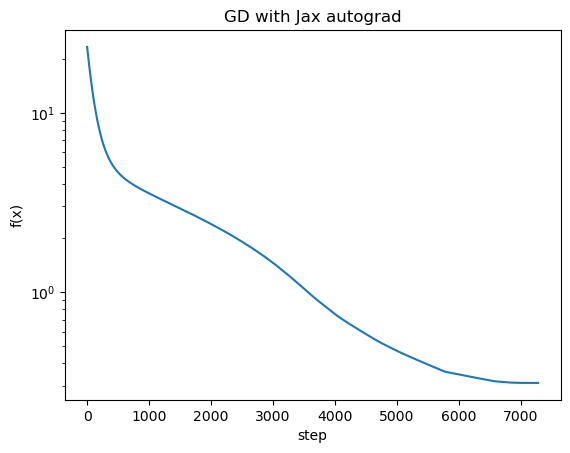

Performance time is 183.255855292 seconds.
||x*|| = 0.7180486141772263, f* = 0.31161443798485006


In [12]:
import time
import matplotlib.pyplot as plt

t1 = time.perf_counter()
df, x_arr = gd(np.ones((n, 1))/3, 0.001, 1e-6)
# df, x_arr = gd(x_star, 0.001, 1e-3)
t2 = time.perf_counter() - t1

plt.plot(df.step, df.f)
plt.xlabel(r'step')
plt.ylabel(r'f(x)')
plt.title('GD with Jax autograd')
plt.yscale('log')
plt.show()

print(f'Performance time is {t2} seconds.')
print(fr'||x*|| = {np.linalg.norm(x_arr[-1])}, f* = {df.f.iloc[-1]}')

In [13]:
0.5*np.power(np.linalg.norm(np.dot(A, np.array(x_arr[-1])) - b), 2)

0.07398209286226064

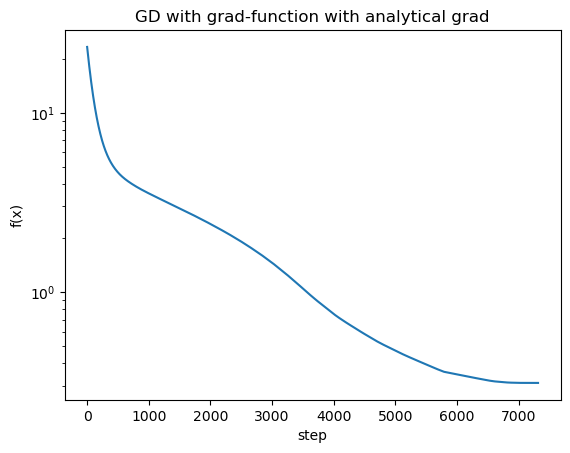

Performance time is 2.6279317919999983 seconds.
||x*|| = 0.7180851523905931, f* = 0.31157033762007585


In [14]:
import time
import matplotlib.pyplot as plt

t1 = time.perf_counter()
df, x_arr = gd(np.ones((n, 1))/3, 0.001, 1e-6, grad_func=grad_func)
# df, x_arr = gd(x_star, 0.001, 1e-3, grad_func=grad_func)
t2 = time.perf_counter() - t1

plt.plot(df.step, df.f)
plt.xlabel(r'step')
plt.ylabel(r'f(x)')
plt.title('GD with grad-function with analytical grad')
plt.yscale('log')
plt.show()

print(f'Performance time is {t2} seconds.')
print(fr'||x*|| = {np.linalg.norm(x_arr[-1])}, f* = {df.f.iloc[-1]}')

# Question 3: Linear Programming Example (3 points)

A cargo plane has three compartments for storing cargo: front, centre, and rear. These
compartments have the following limits on both weight and space:

| Compartment | Weight capacity (tonnes) | Space capacity (cubic metres) |
|-------------|:------------------------:|:-----------------------------:|
| Front       |            10            |              6800             |
| Center      |            16            |              8700             |
| Rear        |            8             |              5300             |

Furthermore, the weight of the cargo in the respective compartments must be the same
proportion of that compartment’s weight capacity to maintain the balance of the plane.
The following four cargoes are available for shipment on the next flight:

| Cargo | Weight (tonnes) | Volume (cubic metres/tonne) | Profit ($ /tonne) |
|-------|:---------------:|:---------------------------:|-------------------|
| C1    |        18       |             480             |        310        |
| C2    |        15       |             650             |        380        |
| C3    |        23       |             580             |        350        |
| C4    |        12       |             390             |        285        |


Any proportion of these cargoes can be accepted. The objective is to determine how
much (if any) of each cargo C1, C2, C3 and C4 should be accepted and how to distribute
each among the compartments so that the total profit for the flight is maximized.
1. Formulate the above problem as a linear program.
2. What assumptions have you made in formulating this problem as a linear program?
3. Solve the problem using `scipy.optimize.linprog` in Python.
4. Solve the problem using the ellipsoid method. Plot the graph showing how the ellipsoid
volume decreases. Count the number of iterations.
5. Sensitivity to the constraint values. What if the available cargoes weight increases/decreases
by 10%? Define which cargo weight has the greatest impact on the total profit. Explain
the dependence between dual variables and changes in the total profit.

## Soltion

### Linear problem formulation

Let $x_{ij}$ - tons cargo in compartment: $ i = \{c_1,c_2,c_3,c_4\}$, $j = \{$front(0), center(1), rear(2)$\}$

And problem is

$$ \max 310 \sum_{j}x_{0,j} + 380 \sum_{j}x_{1,j} + 350 \sum_{j}x_{2,j} + 285 \sum_{j}x_{3,j} $$

subject to
$$ \sum_{j}x_{0,j} \leq 18 \text{ (tons cargo 1)}$$
$$ \sum_{j}x_{1,j} \leq 15 \text{ (tons cargo 2)}$$
$$ \sum_{j}x_{2,j} \leq 23 \text{ (tons cargo 3)}$$
$$ \sum_{j}x_{3,j} \leq 12 \text{ (tons cargo 4)}$$
$$ \sum_{i}x_{i,0} \leq 10 \text{ (weight cap front)}$$
$$ \sum_{i}x_{i,1} \leq 16 \text{ (weight cap center)}$$
$$ \sum_{i}x_{i,2} \leq 8 \text{ (weight cap rear)}$$
$$ 480 x_{0,0} + 650 x_{1,0} + 580 x_{1,0} \leq 6800 \text{ (space cap front)}$$
$$ 480 x_{0,1} + 650 x_{1,1} + 580 x_{1,1} \leq 8700 \text{ (space cap center)}$$
$$ 480 x_{0,2} + 650 x_{1,2} + 580 x_{1,2} \leq 5300 \text{ (space cap rear)}$$
$$ \frac{1}{10}(x_{0,0} + x_{1,0} + x_{2,0}+ x_{3,0}) - \frac{1}{16}(x_{0,1} + x_{1,1} + x_{2,1}+x_{3,1}) = 0$$
$$ \frac{1}{10}(x_{0,0} + x_{1,0} + x_{2,0}+ x_{3,0}) - \frac{1}{8}(x_{0,2} + x_{1,2} + x_{1,2}+x_{3,2}) = 0$$
$$ \forall i,j: x_{i,j} \geq 0 $$

### Assumptions

I believe that the model above fully covers the problem, which means that no assumptions have been made

### Solution with scipy.optimize.linprog

In [28]:
from scipy.optimize import linprog

c = np.reshape(np.array([310, 310, 310,
                         380, 380, 380,
                         350, 350, 350,
                         285, 285, 285]), (12, 1))
'''
               idx = [[c1,f],[c1,c],[c1,r],
                      [c2,f],[c2,c],[c2,r],
                      [c3,f],[c3,c],[c3,r],
                      [c4,f],[c4,c],[c4,r]]
'''

A_ub = np.reshape(np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
                            [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
                            [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
                            [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
                            [480, 0, 0, 650, 0, 0, 580, 0, 0, 390, 0, 0],
                            [0, 480, 0, 0, 650, 0, 0, 580, 0, 0, 390, 0],
                            [0, 0, 480, 0, 0, 650, 0, 0, 580, 0, 0, 390]]),
                  (10, 12))

b_ub = np.reshape(
    np.array([18, 15, 23, 12, 10, 16, 8, 6800, 8700, 5300]), (10, 1))

A_eq = np.reshape(np.array([[.1, -1/16, 0, .1, -1/16, 0, .1, -1/16, 0, .1, -1/16, 0],
                            [.1, 0, -1/8, .1, 0, -1/8, .1, 0, -1/8, .1, 0, -1/8],]),
                  (2, 12))

b_eq = np.reshape([0, 0],
                  (2, 1))

In [16]:
results = linprog(-c,
                  A_ub=A_ub, b_ub=b_ub,
                 A_eq=A_eq, b_eq=b_eq)

In [17]:
idx = ['c1,f','c1,c','c1,r',
       'c2,f','c2,c','c2,r',
       'c3,f','c3,c','c3,r',
       'c4,f','c4,c','c4,r']

for i in range(len(idx)):
    print(idx[i],'=',results.x[i])

c1,f = 0.0
c1,c = 0.0
c1,r = 0.0
c2,f = 10.00000000000016
c2,c = 0.0
c2,r = 4.999999999999534
c3,f = 0.0
c3,c = 12.947368421052566
c3,r = 3.0000000000004645
c4,f = 0.0
c4,c = 3.052631578947436
c4,r = 0.0


In [18]:
print('Total profit is', -results.fun)

Total profit is 12151.578947368465


### Solution with PuLP

In [19]:
from pulp import *

compartment = {"front_comp": {"wcap": 10, "vcap": 6800},
               "center_comp": {"wcap": 16, "vcap": 8700},
               "rear_comp": {"wcap": 8, "vcap": 5300}
               }

cargo = {"cargo1": {"wt": 18, "vol": 480, "profit": 310},
         "cargo2": {"wt": 15, "vol": 650, "profit": 380},
         "cargo3": {"wt": 23, "vol": 580, "profit": 350},
         "cargo4": {"wt": 12, "vol": 390, "profit": 285},
         }

cargoes = list(cargo.keys())
compartments = list(compartment.keys())

prob = LpProblem("Cargo_Problem", LpMaximize)
dec_var = LpVariable.dicts("qty", (cargoes, compartments), lowBound=0)

prob += lpSum(dec_var[i][j]*cargo[i]["profit"]
              for i in cargoes for j in compartments)

# volume constraint
for c in compartment:
    prob += lpSum(dec_var[i][c]*cargo[i]["vol"]
                  for i in cargoes) <= compartment[c]["vcap"], c + "_volume_constraint"

 # weight constraint
for c in compartment:
    prob += lpSum(dec_var[i][c]
                  for i in cargoes) <= compartment[c]["wcap"], c + "_weight_constraint"

# cargo available constraint
for c in cargoes:
    prob += lpSum(dec_var[c][i]
                  for i in compartments) <= cargo[c]["wt"], c + "_cargo_constraint"

# balance constraint
f = 1/compartment["front_comp"]["wcap"]
c = 1/compartment["center_comp"]["wcap"]
r = 1/compartment["rear_comp"]["wcap"]

prob += lpSum(dec_var[i]["front_comp"] for i in cargoes)*f \
    == lpSum(dec_var[i]["center_comp"] for i in cargoes)*c \
    == lpSum(dec_var[i]["rear_comp"] for i in cargoes)*r, "balance constraint"

print(prob)

prob.solve()
print('\n')
print(LpStatus[prob.status])

Cargo_Problem:
MAXIMIZE
310*qty_cargo1_center_comp + 310*qty_cargo1_front_comp + 310*qty_cargo1_rear_comp + 380*qty_cargo2_center_comp + 380*qty_cargo2_front_comp + 380*qty_cargo2_rear_comp + 350*qty_cargo3_center_comp + 350*qty_cargo3_front_comp + 350*qty_cargo3_rear_comp + 285*qty_cargo4_center_comp + 285*qty_cargo4_front_comp + 285*qty_cargo4_rear_comp + 0
SUBJECT TO
front_comp_volume_constraint: 480 qty_cargo1_front_comp
 + 650 qty_cargo2_front_comp + 580 qty_cargo3_front_comp
 + 390 qty_cargo4_front_comp <= 6800

center_comp_volume_constraint: 480 qty_cargo1_center_comp
 + 650 qty_cargo2_center_comp + 580 qty_cargo3_center_comp
 + 390 qty_cargo4_center_comp <= 8700

rear_comp_volume_constraint: 480 qty_cargo1_rear_comp
 + 650 qty_cargo2_rear_comp + 580 qty_cargo3_rear_comp
 + 390 qty_cargo4_rear_comp <= 5300

front_comp_weight_constraint: qty_cargo1_front_comp + qty_cargo2_front_comp
 + qty_cargo3_front_comp + qty_cargo4_front_comp <= 10

center_comp_weight_constraint: qty_cargo1_

In [20]:
for v in prob.variables():
    print(v.name, "=", v.varValue)
    
print('\n')
print("Total Profit = ", value(prob.objective))

qty_cargo1_center_comp = 0.0
qty_cargo1_front_comp = 0.0
qty_cargo1_rear_comp = 0.0
qty_cargo2_center_comp = 0.0
qty_cargo2_front_comp = 7.0
qty_cargo2_rear_comp = 8.0
qty_cargo3_center_comp = 12.947368
qty_cargo3_front_comp = 3.0
qty_cargo3_rear_comp = 0.0
qty_cargo4_center_comp = 3.0526316
qty_cargo4_front_comp = 0.0
qty_cargo4_rear_comp = 0.0


Total Profit =  12151.578806


### Solution with Ellipsoud method

In [21]:
c_q = np.reshape(np.array([310, 310, 310,
                         380, 380, 380,
                         350, 350, 350,
                         285, 285, 285]), (12, 1))
'''
               idx = [[c1,f],[c1,c],[c1,r],
                      [c2,f],[c2,c],[c2,r],
                      [c3,f],[c3,c],[c3,r],
                      [c4,f],[c4,c],[c4,r]]
'''

A_ub = np.reshape(np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
                            [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
                            [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
                            [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
                            [480, 0, 0, 650, 0, 0, 580, 0, 0, 390, 0, 0],
                            [0, 480, 0, 0, 650, 0, 0, 580, 0, 0, 390, 0],
                            [0, 0, 480, 0, 0, 650, 0, 0, 580, 0, 0, 390],
                            [.1, -1/16, 0, .1, -1/16, 0, .1, -1/16, 0, .1, -1/16, 0],
                            [.1, 0, -1/8, .1, 0, -1/8, .1, 0, -1/8, .1, 0, -1/8],
                            [-0.1, 1/16, 0, -0.1, 1/16, 0, -0.1, 1/16, 0, -0.1, 1/16, 0],
                            [-0.1, 0, 1/8, -0.1, 0, 1/8, -0.1, 0, 1/8, -0.1, 0, 1/8]]),
                  (14, 12))

b_ub = np.reshape(
    np.array([18, 15, 23, 12, 10, 16, 8, 6800, 8700, 5300, 0, 0, 0, 0]), (14, 1))

In [22]:
# def feasible_func(x):
#     return A_ub @ x - b_ub

def grad_func(x):
    return -c_q

def ellipsoid_method(x_c, P, W, n = 12, grad_func = grad_func):
    k = 0
    vol = []
    while k < 100:
        grad = grad_func(x_c)
        grad = 1/(np.sqrt(grad.T @ P @ grad)) * grad
        x_c = x_c - (1 / (n + 1))* P @ grad
        P = (n**2 / (n**2 - 1)) * (P - (2 / (n + 1)) * P @ grad @ grad.T @ P)
        k += 1
        L = np.linalg.cholesky(np.linalg.inv(P))
        vol.append(vol_eps(L))
    return x_c, P, vol, k

In [23]:
R = 1
P_0 = R**2 * np.eye(12)
x_c_0 = np.zeros([12,1])

In [24]:
x_c, P, vol_arr, k = ellipsoid_method(x_c_0, P_0, A)

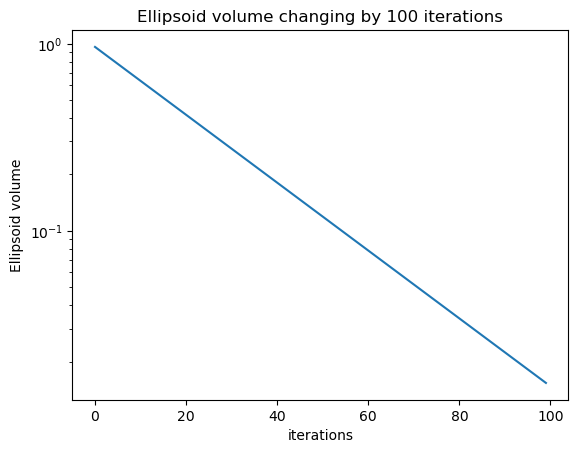

In [25]:
plt.plot(range(k), vol_arr)
plt.title('Ellipsoid volume changing by 100 iterations')
plt.xlabel('iterations')
plt.ylabel('Ellipsoid volume')
plt.yscale('log')
plt.show()

### Sensativity

In [29]:
def linprog_solution(b_var):
    results = linprog(-c,
                  A_ub=A_ub, b_ub=b_var,
                 A_eq=A_eq, b_eq=b_eq)
    return results.fun

In [30]:
for i in range(4):
    b1 = b_ub.copy()
    b1[i] = 1.1*b1[i]
    print(f'If we increase weight constraint by 10% for cargo{i+1}, profit will be equal',
          - linprog_solution(b1))

If we increase weight constraint by 10% for cargo1, profit will be equal 12151.578947368465
If we increase weight constraint by 10% for cargo2, profit will be equal 12181.57894736847
If we increase weight constraint by 10% for cargo3, profit will be equal 12151.578947368465
If we increase weight constraint by 10% for cargo4, profit will be equal 12151.578947368465


In [31]:
for i in range(4):
    b1 = b_ub.copy()
    b1[i] = 0.9*b1[i]
    print(f'If we increase weight constraint by 10% for cargo{i+1}, profit will be equal',
          - linprog_solution(b1))

If we increase weight constraint by 10% for cargo1, profit will be equal 12151.578947368465
If we increase weight constraint by 10% for cargo2, profit will be equal 12091.578947368467
If we increase weight constraint by 10% for cargo3, profit will be equal 12151.57894736845
If we increase weight constraint by 10% for cargo4, profit will be equal 12151.578947368465


In [33]:
12181.57894736847/12151.578947368465*100 - 100, 100 - 12091.578947368467/12151.578947368465*100

(0.24688149688154226, 0.49376299376298505)

#### Conclusion

* We can see that only one initial bound changing influence on the finite solution (total profit value).
* This initial bound changing is the weight capacity cargo2 changing.
* It's can be explaind by profit per ton value, because exectly cargo2 have the biggest of value of the profit.
* If we increase this parameter by 10%, total profit value increased on 0.24%.
* If we decrease this parameter by 10%, total profit value decreased on 0.49%.